In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile
import random
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skimage import io, color, feature
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

In [4]:
with zipfile.ZipFile("/kaggle/input/dogs-vs-cats/train.zip","r") as z:
    z.extractall(".")
    
with zipfile.ZipFile("/kaggle/input/dogs-vs-cats/test1.zip","r") as z:
    z.extractall(".")

In [5]:
filenames = os.listdir("train")
labels = []
for filename in filenames:
    if "cat" in filename:
        labels.append('cat')
    elif "dog" in filename:
        labels.append('dog')
    
df = pd.DataFrame({
    'Filename': filenames,
    'Label': labels
})

df.head()

,Filename,Label
0,cat.7720.jpg,cat
1,cat.2435.jpg,cat
2,dog.3362.jpg,dog
3,dog.4841.jpg,dog
4,dog.351.jpg,dog


In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Filename  25000 non-null  object
 1   Label     25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB


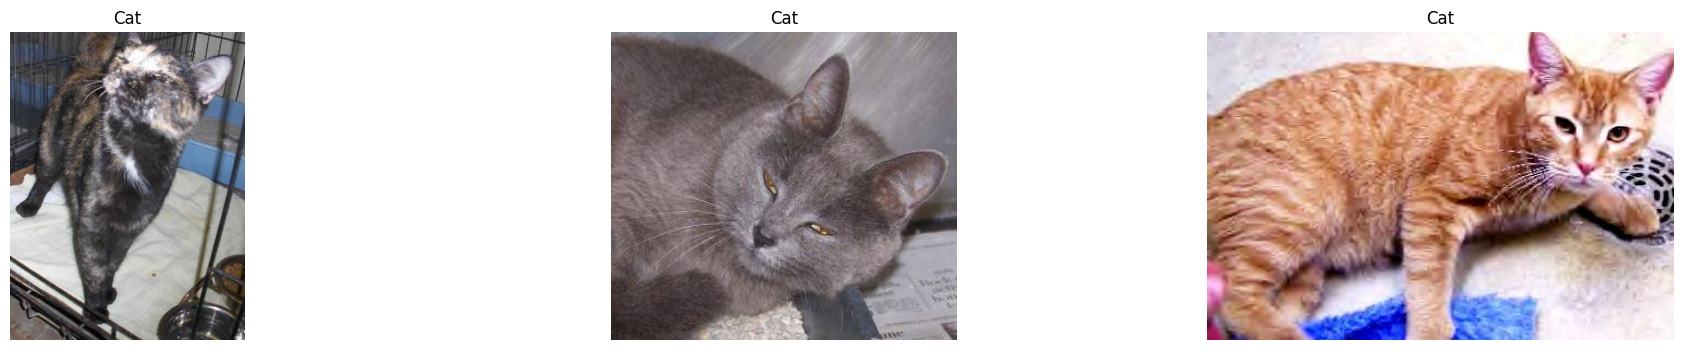

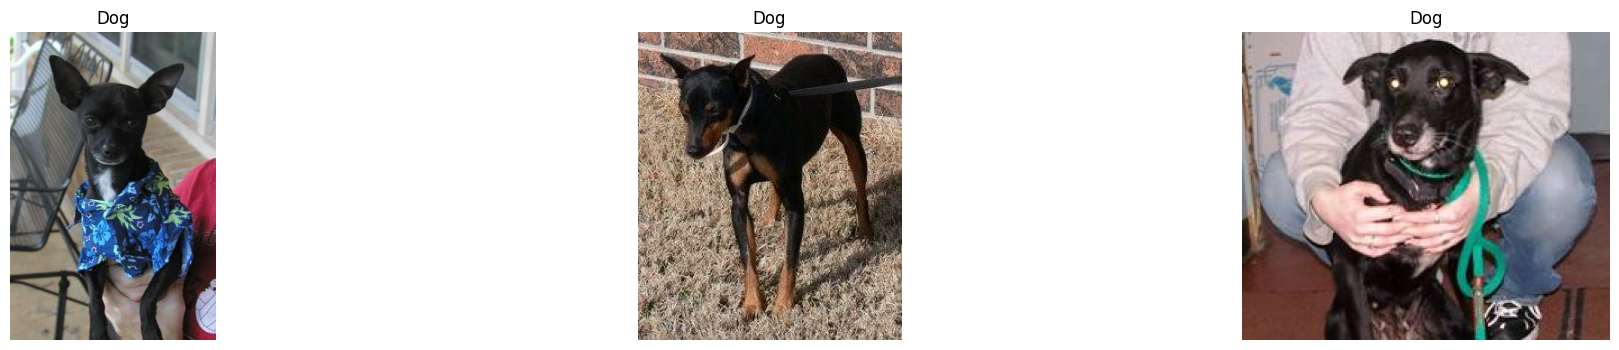

In [7]:
# Function to display images
def display_images(image_paths, category):
    plt.figure(figsize=(24, 4))
    for i, img_path in enumerate(image_paths):
        plt.subplot(1, 3, i + 1)
        img = mpimg.imread(os.path.join('train', img_path))
        plt.imshow(img)
        plt.title(category)
        plt.axis('off')
    plt.show()

# Selecting three random images of cats
cat_images = [filename for filename in filenames if 'cat' in filename]
selected_cat_images = random.sample(cat_images, 3)

# Selecting three random images of dogs
dog_images = [filename for filename in filenames if 'dog' in filename]
selected_dog_images = random.sample(dog_images, 3)

# Display the images
display_images(selected_cat_images, 'Cat')
display_images(selected_dog_images, 'Dog')

# Data Prepration


In [8]:
# Constants
IMAGE_WIDTH, IMAGE_HEIGHT = 224, 224
BATCH_SIZE = 32

In [9]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory='train/',
    x_col='Filename',
    y_col='Label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory='train/',
    x_col='Filename',
    y_col='Label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [19]:
# Load the VGG16 model, pretrained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [22]:
# Create the model
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [25]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [27]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=25
)

Epoch 1/25


I0000 00:00:1707925876.224482      86 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 [==============================] - 116s 164ms/step - loss: 0.2605 - accuracy: 0.8848 - val_loss: 0.1784 - val_accuracy: 0.9255
Epoch 2/25
625/625 [==============================] - 105s 168ms/step - loss: 0.1652 - accuracy: 0.9316 - val_loss: 0.1923 - val_accuracy: 0.9195
Epoch 3/25
625/625 [==============================] - 105s 169ms/step - loss: 0.1417 - accuracy: 0.9411 - val_loss: 0.1662 - val_accuracy: 0.9291
Epoch 4/25
625/625 [==============================] - 106s 169ms/step - loss: 0.1129 - accuracy: 0.9549 - val_loss: 0.1671 - val_accuracy: 0.9273
Epoch 5/25
625/625 [==============================] - 106s 169ms/step - loss: 0.1019 - accuracy: 0.9596 - val_loss: 0.1843 - val_accuracy: 0.9293
Epoch 6/25
625/625 [==============================] - 105s 169ms/step - loss: 0.0881 - accuracy: 0.9650 - val_loss: 0.1789 - val_accuracy: 0.9309
Epoch 7/25
625/625 [==============================] - 106s 169ms/step - loss: 0.0728 - accuracy: 0.9718 - val_loss: 0.1771 - val_accura

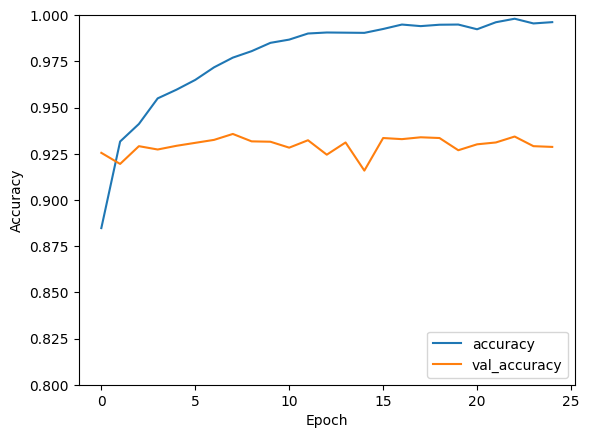

In [28]:
# Evaluate the model
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1])
plt.legend(loc='lower right')

# Make Predictions with Test Data

In [29]:
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/test1.zip', 'r') as test1_zip:
    test1_zip.extractall('.')  

In [30]:
test_dir = "../working/test1/"
filenames = os.listdir(test_dir)
test_data = pd.DataFrame({"Filename": filenames})
test_data.head()

,Filename
0,10338.jpg
1,7624.jpg
2,5506.jpg
3,5324.jpg
4,7863.jpg


In [31]:
test_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_gen.flow_from_dataframe(
    dataframe=test_data,
    directory='test1/',
    x_col='Filename',
    y_col=None,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode=None,
)

Found 12500 validated image filenames.


In [32]:
test1_predict = model.predict(test_generator)

391/391 [==============================] - 59s 151ms/step


In [33]:
test1_predict

array([[1.0000000e+00],
       [1.0000000e+00],
       [6.5709852e-02],
       ...,
       [9.9999988e-01],
       [1.4422238e-07],
       [7.8470972e-09]], dtype=float32)

In [34]:
threshold = 0.5
test_data['Label'] = np.where(test1_predict > threshold, 'dog', 'cat')

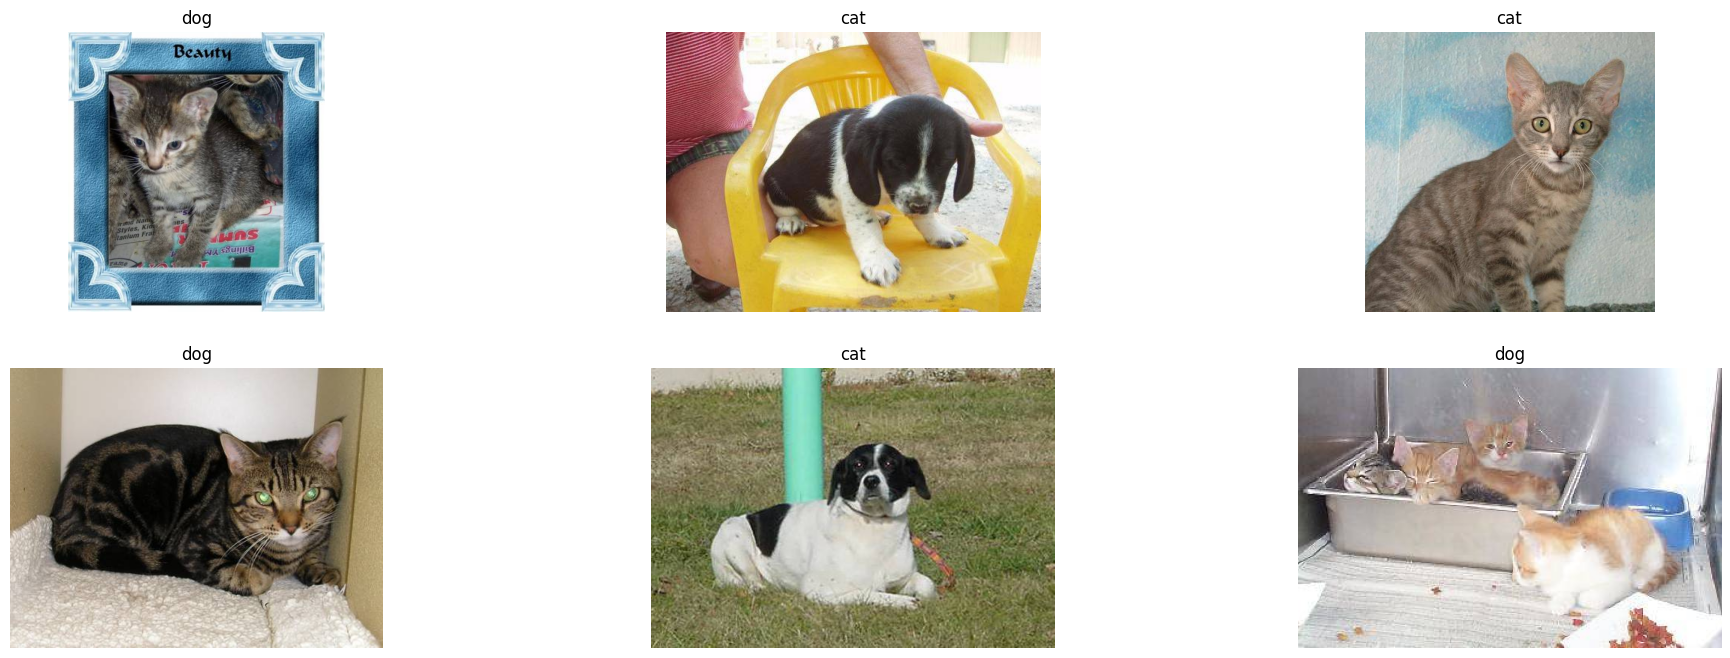

In [35]:
sample_test = test_data.sample(n=6)
plt.figure(figsize=(24, 8)) 

subplot_index = 1
for _, row in sample_test.iterrows():
    image_path = os.path.join(test_dir, row['Filename'])
    img = mpimg.imread(image_path)
    plt.subplot(2, 3, subplot_index)
    plt.imshow(img)
    plt.title(row['Label'])
    plt.axis('off')
    subplot_index += 1

plt.show()
